In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.metrics import f1_score,  precision_score, recall_score, hamming_loss
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.utils.class_weight import compute_class_weight

from skmultilearn.model_selection import iterative_train_test_split
from skmultilearn.adapt import MLkNN
from skmultilearn.problem_transform import ClassifierChain
from skmultilearn.ensemble import RakelD
from skmultilearn.model_selection.measures import get_combination_wise_output_matrix

from joblib import dump

## **Load Cleaned Data**

In [4]:
# Load the cleaned datasets
df_user_inputs = pd.read_csv('../dataset/user_inputs_cleaned.csv')
df_labels = pd.read_csv('../dataset//labels_cleaned.csv')

# Remove unnecessary index columns
df_user_inputs.drop(df_user_inputs.columns[0], axis=1, inplace=True)
df_labels.drop(df_labels.columns[0], axis=1, inplace=True)

# Ensure alignment
assert len(df_labels) == len(df_user_inputs), "Datasets do not align!"

print(df_user_inputs.shape)
df_user_inputs.head(10)

(3974, 1)


,text
0,er is een teek op mijn been ik ben bang dat di...
1,er is een teek op mijn rug en ik krijg hem er ...
2,op mijn been zit een teek ik heb hem geprobeer...
3,ik heb allergieen
4,huid
5,roodheid
6,schilfering
7,ik heb wratten onder mijn voet
8,ik heb gisteren naar het bos geweest en zie nu...
9,ik voelde iets prikken


In [14]:
df_labels.head()

,"Niet lekker voelen, algehele malaise",Beenklachten,Bloedneus,Misselijkheid en overgeven,Brandwond,Buikpijn,Suikerziekte (ontregeld),Diarree,Duizeligheid,Gebitsklachten,...,Coronavirus,Knieklachten,Liesklachten,Elleboogklachten,Schouderklachten,Oorsuizen,Hand- en polsklachten,Enkelklachten,Dikke enkels of voeten,Vingerklachten
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
# Determine model baseline
label_frequencies = df_labels.sum().sort_values(ascending=False)
label_frequencies / df_labels.shape[0]

Huidklachten                            0.088827
Beenklachten                            0.072723
Buikpijn                                0.062154
Oorklachten                             0.052843
Misselijkheid en overgeven              0.037242
                                          ...   
Liesklachten                            0.005033
Tekenbeet                               0.005033
Verdrinking                             0.005033
Verwonding aan de buik                  0.005033
Niet lekker voelen, algehele malaise    0.002516
Length: 74, dtype: float64

We see that if we predict every time the label with the highest frequency (Huidklachten), our model will be correct around 9% of the time. We want our model to perform at least better than this 9% threshold

## **Prepare Data to Model Format**

We changed the process of splitting the dataset into train/val/test sets, to accomodate the nature of multi-label classification. Instead of using a traditional method, we employ iterative stratified sampling `iterative_train_test_split`, to provide a well-balanced distribution of all label combinations in both training and test sets.

In [7]:
## Split data to train:val:test

# Prepare data for iterative train test split
# X must be 2D np.ndarray and y must be 2D binary np.ndarray
X_texts = df_user_inputs['text'].values
X_texts = X_texts.reshape(-1, 1)
y = df_labels.values

# Split the data 60:20:20 with multi-label stratification
train_texts, y_train, test_texts, y_test = iterative_train_test_split(X_texts, y, test_size = 0.2)
#val_texts, y_val, test_texts, y_test = iterative_train_test_split(tmp_texts, y_tmp, test_size = 0.5)

# Sanity checks to confirm the shapes of the datasets
assert train_texts.shape[0] == y_train.shape[0], "Mismatch in train data and labels"
assert test_texts.shape[0] == y_test.shape[0], "Mismatch in test data and labels"

train_texts, test_texts = train_texts.ravel(), test_texts.ravel()
#val_texts = val_texts.ravel()

print(train_texts.shape, y_train.shape, test_texts.shape)
train_texts

(3175,) (3175, 74) (799,)


array(['er is een teek op mijn rug en ik krijg hem er niet af',
       'ik heb allergieen', 'schilfering', ...,
       'vannacht met slapen denk ik gekke beweging gemaakt want mn nek is nu helemaal stijf kan niet meer naar rechts kijken',
       'heb al langere tijd pijn in mn nek krijg dan soms tintelingen over mijn arm heb dan ook minder kracht in mijn arm',
       'doet zeer als ik mn hoofd beweeg'], dtype=object)

In [8]:
## Vectorize our text data

# Initialize the TF-IDF Vectorizer
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))

# Fit and Transform the Training Data
X_train = vectorizer.fit_transform(train_texts)

# We only transform, rather than fit_transform on val and test sets, to avoid data leakage
#X_val = vectorizer.transform(val_texts)
X_test = vectorizer.transform(test_texts)

# Convert arrays from sparse to dense
X_train, X_test = X_train.toarray(), X_test.toarray()
#X_val = X_val.toarray()

X_train.shape, X_test.shape

((3175, 5000), (799, 5000))

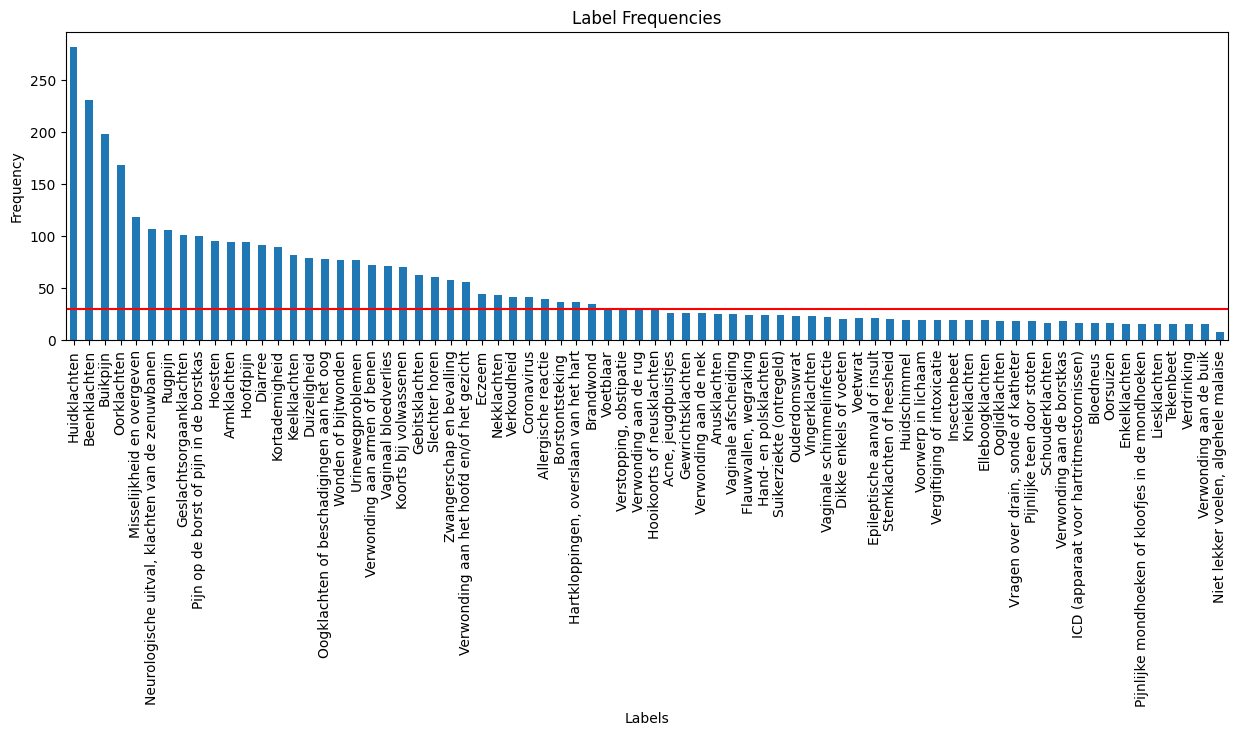

In [9]:
def visualize_frequencies(y, hline=0):
  # Calculate the original frequencies of each label
  label_frequencies_original = df_labels.sum(axis=0).sort_values(ascending=False)

  # Calculate the frequencies
  label_frequencies_new = y.sum(axis=0)

  # Create a df for the frequencies
  df_new_freq = pd.DataFrame(label_frequencies_new, index=df_labels.columns, columns=['frequency'])

  # Sort the frequencies based on the original order
  df_new_freq = df_new_freq.loc[label_frequencies_original.index]

  # Plot the frequencies in descending order based on the original frequencies
  plt.figure(figsize=(15, 4))
  df_new_freq['frequency'].plot(kind='bar')
  plt.title('Label Frequencies')
  plt.xlabel('Labels')
  plt.ylabel('Frequency')
  plt.xticks(rotation=90)
  plt.axhline(y=hline, color='red', linestyle='-')
  plt.show()

visualize_frequencies(y_train, hline=30)

In [10]:
## Handle class imbalance
# Custom oversample minority classes in a multi-label setting
def oversample_X_vectorized(X, y, threshold=35):
    """
    Perform custom oversampling on the minority classes in the dataset.

    Args:
        X (numpy.ndarray): Feature data.
        y (numpy.ndarray): Label data.
        threshold (int): The threshold below which a class is considered a minority class.

    Returns:
        numpy.ndarray: The oversampled feature data.
        numpy.ndarray: The oversampled label data.
    """

    # Identify minority classes
    minority_labels = (y.sum(axis=0) < threshold)
    # Identify instances with minority class labels
    minority_instances = y[:, minority_labels].sum(axis=1) > 0
    # Oversample these instances
    X_oversampled = np.vstack([X[minority_instances]] * 1)
    y_oversampled = np.vstack([y[minority_instances]] * 1)
    # Combine with original data
    X_combined = np.vstack([X, X_oversampled])
    y_combined = np.vstack([y, y_oversampled])
    return X_combined, y_combined

# Apply the oversampling function to training data
X_train_oversampled, y_train_oversampled = oversample_X_vectorized(X_train, y_train, threshold=30)

# Sanity check
assert X_train_oversampled.shape[0] == y_train_oversampled.shape[0], "Mismatch in oversampled train data and labels"
X_train_oversampled.shape, y_train_oversampled.shape

((3907, 5000), (3907, 74))

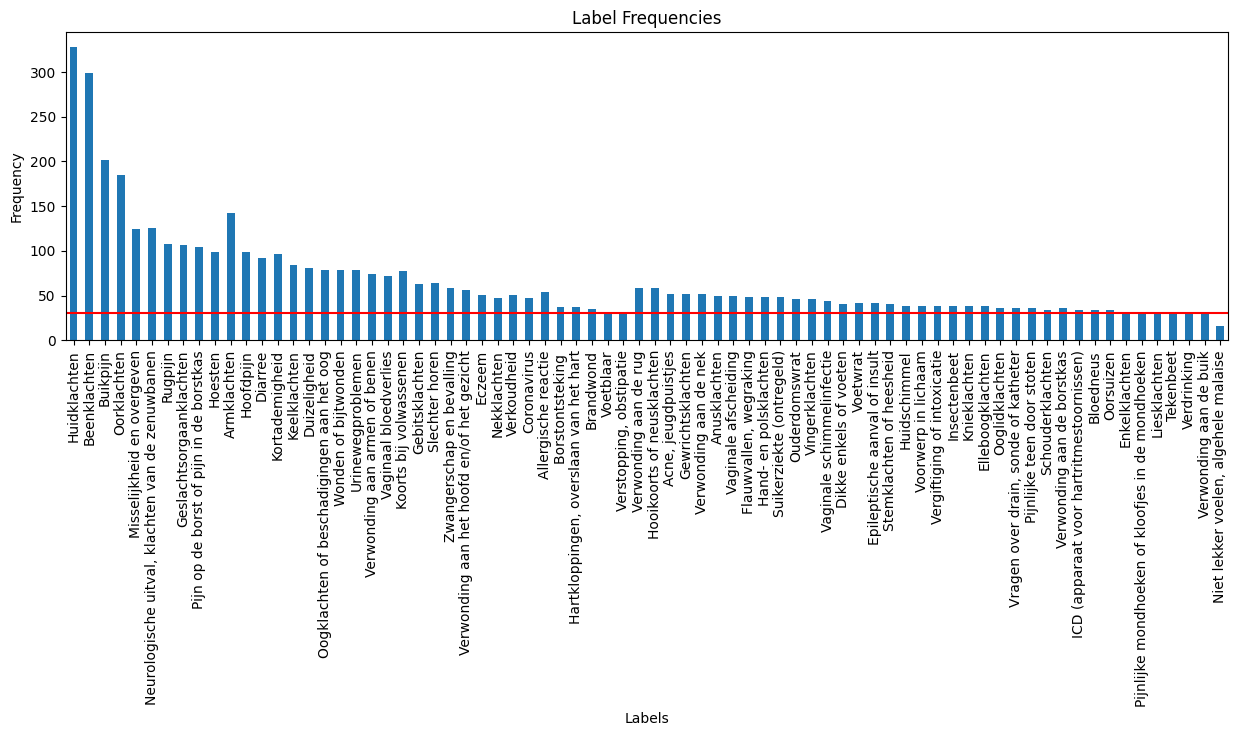

In [11]:
visualize_frequencies(y_train_oversampled, hline=30)

## **Model Building: ML Algorithms (Baseline Model)**

For simplicity, we train and evaluate base classifiers with OneVsRestClassifier. We select classifiers that are known to work well with multi-label text classification, such as Naive Bayes, SVM, and Logistic Regression.

To handle class imbalance, we consider the following:
- Class weights in loss function
- Evaluation metrics: F1 score (micro) for individual labels and Hamming loss for overall metrics (i.e. evaluate label prediction rather than label combination)

We identify the best-performing classifier based on the F1 score and Hamming Loss. Then we proceed to test this classifer with more advanced techniques that consider label correlations, i.e. Classifier Chains (CC) and Random k-Labelsets (RAkEL).

In [12]:
def clf_multilabel(clf_ml_name, clf_base, X_train=X_train_oversampled, y_train=y_train_oversampled, X_test=X_test, y_test=y_test):
    """
    Evaluate a base classifier with different multi-label classification strategies.

    Args:
        clf_ml_name (str): Name of the multi-label classification strategy to use.
        clf_base (BaseEstimator): The base classifier to be used in the multi-label strategy.
        X_train (numpy.ndarray): Training feature data.
        y_train (numpy.ndarray): Training label data.
        X_test (numpy.ndarray): Test feature data.
        y_test (numpy.ndarray): Test label data.

    Returns:
        dict: A dictionary containing the method, classifier name, F1 Score (Micro), and Hamming Loss.
    """

    if clf_ml_name == "OneVsRestClassifier":
        clf = OneVsRestClassifier(clf_base)
    elif clf_ml_name == "ClassifierChain":
        clf = ClassifierChain(clf_base)
    elif clf_ml_name == "Rakel":
        k = int(0.1 * y_train.shape[1])  # 10% of the total number of labels
        clf = RakelD(base_classifier=clf_base, labelset_size=k)

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    return {
        'Method': clf_ml_name,
        'Classifier Name': type(clf_base).__name__,
        'F1 Score (Micro)': f1_score(y_test, y_pred, average='micro'),
        'Precision': precision_score(y_test, y_pred, average='micro'),
        'Recall': recall_score(y_test, y_pred, average='micro'),
        'Hamming Loss': hamming_loss(y_test, y_pred)
    }

In [ ]:
# Evaluate base classifiers with OneVsRestClassifier
base_classifiers = {
    'GaussianNB': GaussianNB(),
    'LinearSVC': LinearSVC(class_weight='balanced'),
    'LogisticRegression': LogisticRegression(class_weight='balanced'),
}

multilabel_classifiers = ["OneVsRestClassifier"] #, "ClassifierChain", "Rakel"]

# Collect all performance metrics
all_performance_metrics = []


for name, clf in base_classifiers.items():
  for ml_clf in multilabel_classifiers:
      performance_metrics = clf_multilabel(ml_clf, clf)
      all_performance_metrics.append(performance_metrics)

# Identify the best classifier based on F1 Score
best_classifier_name = max(all_performance_metrics, key=lambda x: x['F1 Score (Micro)'])['Classifier Name']
best_classifier = base_classifiers[best_classifier_name]

# Use the best classifier with Classifier Chains and Random k-Labelsets
all_performance_metrics.append(clf_multilabel("ClassifierChain", best_classifier))
all_performance_metrics.append(clf_multilabel("Rakel", best_classifier))

In [21]:
# Convert to DataFrame for easier analysis
df_performance = pd.DataFrame(all_performance_metrics)
df_performance.set_index(['Method', 'Classifier Name'], inplace=True)
df_performance

F1 Score (Micro)  Precision    Recall  \
Method              Classifier Name                                             
OneVsRestClassifier GaussianNB                  0.175624   0.163832  0.189245   
                    LinearSVC                   0.545145   0.604534  0.496381   
                    LogisticRegression          0.579251   0.540807  0.623578   
ClassifierChain     LogisticRegression          0.530450   0.462664  0.621510   

                                        Hamming Loss  
Method              Classifier Name                   
OneVsRestClassifier GaussianNB              0.029057  
                    LinearSVC               0.013547  
                    LogisticRegression      0.014816  
ClassifierChain     LogisticRegression      0.017995

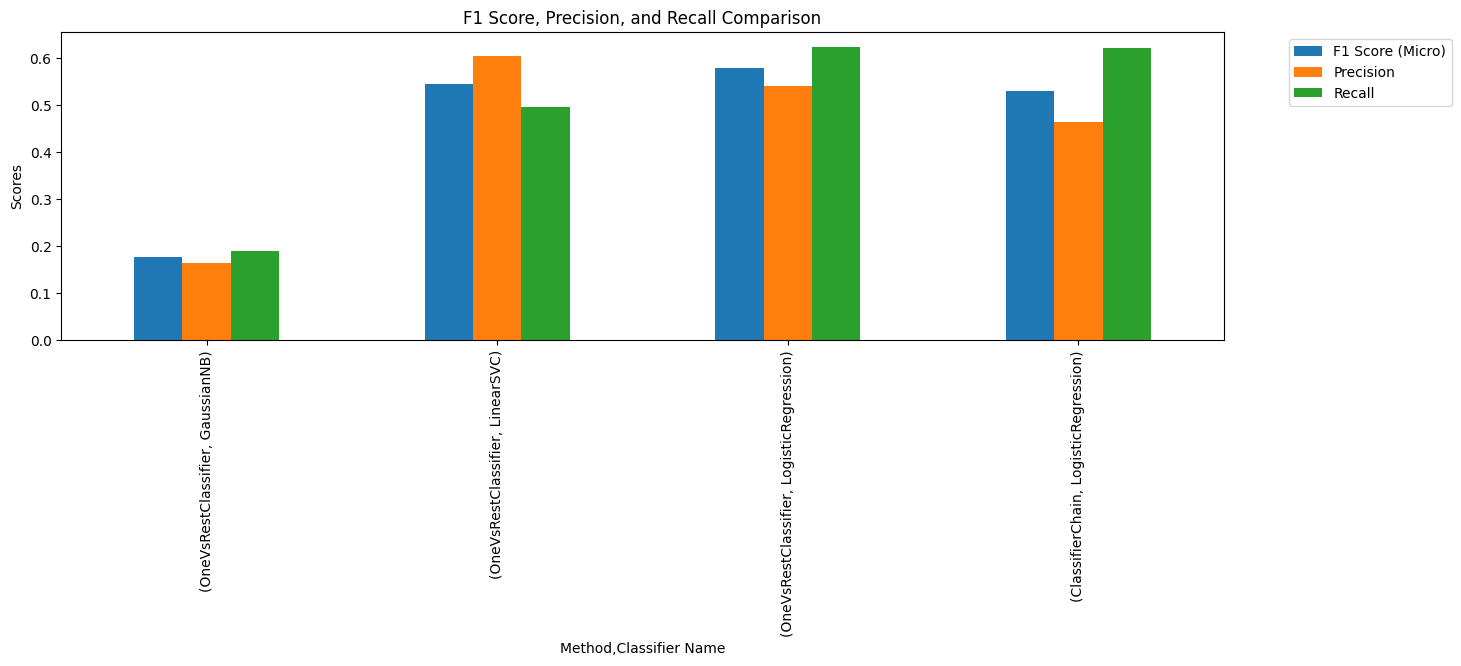

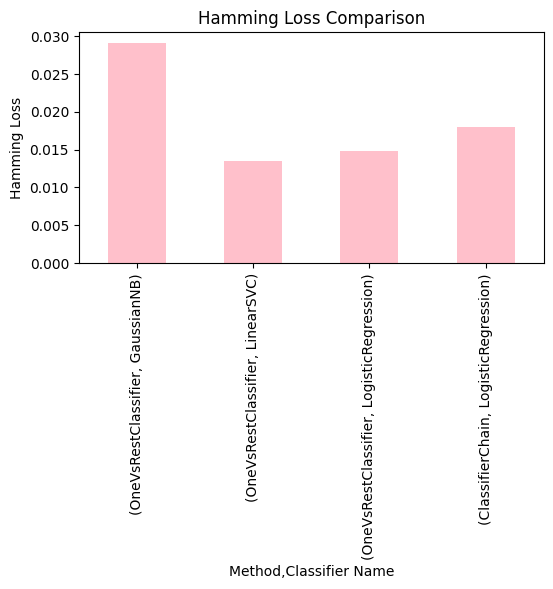

In [22]:
# Plot for F1 Score, Precision, and Recall
plt.figure(figsize=(15, 4))
df_performance[['F1 Score (Micro)', 'Precision', 'Recall']].plot(kind='bar', ax=plt.gca())
plt.title('F1 Score, Precision, and Recall Comparison')
plt.ylabel('Scores')
#plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Plot for Hamming Loss
plt.figure(figsize=(6, 3))
df_performance['Hamming Loss'].plot(kind='bar', ax=plt.gca(), color='pink')
plt.title('Hamming Loss Comparison')
plt.ylabel('Hamming Loss')
plt.xticks(rotation=90)
plt.show()

Best performing classifier is LogisticRegression with OneVsRestClassifier with:
F1 (micro) = 0.59, Precision = 0.55, Recall = 0.63, Hamming Loss = 0.014

So we use this as our baseline model. A simple OneVsRestClassifier working makes sense, since from our EDA, we see most user inputs (84%) are only associated with 1 label.

Unfortunately Naive Bayes doesn't have an option for balanced class weights, but this is good to show the significant reduction in accuracy (~2x) when you don't consider the class weights.

Now we serial the best ML model

In [23]:
# Get the best classifier to serialize later
best_clf = best_classifier
best_clf = OneVsRestClassifier(best_clf)
best_clf.fit(X_train, y_train)

OneVsRestClassifier(estimator=LogisticRegression(class_weight='balanced'))

In [26]:
dump(best_clf, '../models/model_sklearn.joblib')

['../models/model_sklearn.joblib']